## Import & Load

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from localfunc import reduce_ram_usage
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
import gc
from category_encoders import BinaryEncoder

In [29]:
print("Data loading...")
train = pd.read_csv("./data/train_V2.csv")
test = pd.read_csv("./data/test_V2.csv")
print("Data loaded!")

Data loading...
Data loaded!


In [ ]:
#sampleing

train = train.head(500000)

### Check (just in case)

In [5]:
test.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

## Pre-Processing

### Drop null column

In [30]:
print("Pre-Processing...")
for i in train.columns.to_list() :
    train.drop(index=train[train[i].isnull()==True].index, inplace=True)

train_bak_null = train.copy() #--

Pre-Processing...


### Drop Outlier

In [31]:
def dropIdx(df, idx) :
    df.drop(index=idx, inplace=True)
    dropIdx.dpIdx_sum +=len(idx)
    return df
dropIdx.dpIdx_sum = 0

In [32]:
print("Droping Outliers...")
train = train_bak_null.copy() #--
vip_features = ["assists","boosts","DBNOs","heals","kills","killStreaks","walkDistance", "revives", "roadKills", "vehicleDestroys"]

group = train.groupby('groupId').count()
train = dropIdx(train, train[train.groupId.isin(group[group["Id"]>group["Id"].quantile(0.9999)].index)==True].index) #수치고려 가능

for col in (vip_features + ["damageDealt","longestKill", "rideDistance", "swimDistance","weaponsAcquired", "matchDuration"]):
    train = dropIdx(train, train[train[col]>train[col].quantile(0.999)].index)
 
for col in vip_features:
    train = dropIdx(train, train[train["walkDistance"]<train[col]].index)

train = dropIdx(train, train[train.groupby('matchId')['kills'].transform('max')  > train.groupby('matchId')['Id'].transform('count')  ].index)
train = dropIdx(train, train[(train['rideDistance']==0) & (train['roadKills']>0)  ].index)

print(f"{dropIdx.dpIdx_sum} Columns has deleted!") 

del vip_features, group      

Droping Outliers...
78252 Columns has deleted!


### Encoding (필요가 있는지는 잘 모르겠음)

In [33]:
print("Encoding matchType...")
train = train_bak_null.copy() #--

mapper = lambda x: 'normal' if ('normal' in x) or ('crash' in x)or ('flare' in x)else x 
train["matchType"]=train["matchType"].apply(mapper)

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) else 'normal' if ('normal' in x) else 'squad' 
train["matchType"]=train["matchType"].apply(mapper)

train = pd.concat([train,pd.get_dummies(train["matchType"])], axis=1)

del mapper

Encoding matchType...


### Make Columns

    - groupId
    - matchId
    - matchType
    - maxPlace (≈numGroups)

In [61]:
print("Making columns...")
train["killPlace"] = train.groupby("matchId")["kills"].transform('rank', ascending=False)
#data leakage 없는 killPlace data

stat_feature = ["assists","boosts","DBNOs","heals","kills","killStreaks","walkDistance", "revives", "roadKills", "vehicleDestroys","damageDealt","longestKill", "rideDistance", "swimDistance","weaponsAcquired"]
stat_list = ["max","mean","median","min"]
for col in stat_feature :
    for stat in stat_list:
        pd.concat([train,train.groupby("groupId")[col].transform(stat).rename(f"{col}_{stat}")], axis=1) 
        pd.concat([train,train.groupby("matchId")[f"{col}_{stat}"].transform('rank', ascending=False).rename(f"{col}_{stat}Place")], axis=1)
#group별 column stats, match별 group stats 순위

print(len(stat_feature)*len(stat_list)+1, "columns Made!")

Making columns...


## Predict - Evaluation

In [59]:
train.groupby("groupId")["kills"].transform("max")

0          4
1          2
2          2
3          0
4          1
          ..
4446961    2
4446962    0
4446963    0
4446964    2
4446965    2
Name: kills, Length: 4446965, dtype: int8

### Parameter Turning

### Prediction

In [53]:
train = reduce_ram_usage(train)

Memory usage after optimization is: 1430.97 MB
Decreased by 59.0%


In [54]:
features = train.drop(["Id","groupId", "matchType","matchId","winPlacePerc"], axis=1) #all
target = train["winPlacePerc"]
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=589)


In [55]:
print("Fitting...")
model = LGBMRegressor()
model.fit(train_X, train_y)

Fitting...


LGBMRegressor()

In [56]:
pred_y = model.predict(test_X)
print("test MAE : ",np.round(mean_absolute_error(pred_y, test_y),6))

test MAE :  0.059835


In [57]:
pred_y = model.predict(train_X)
print("train MAE : ",np.round(mean_absolute_error(pred_y, train_y),6))

train MAE :  0.059726


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

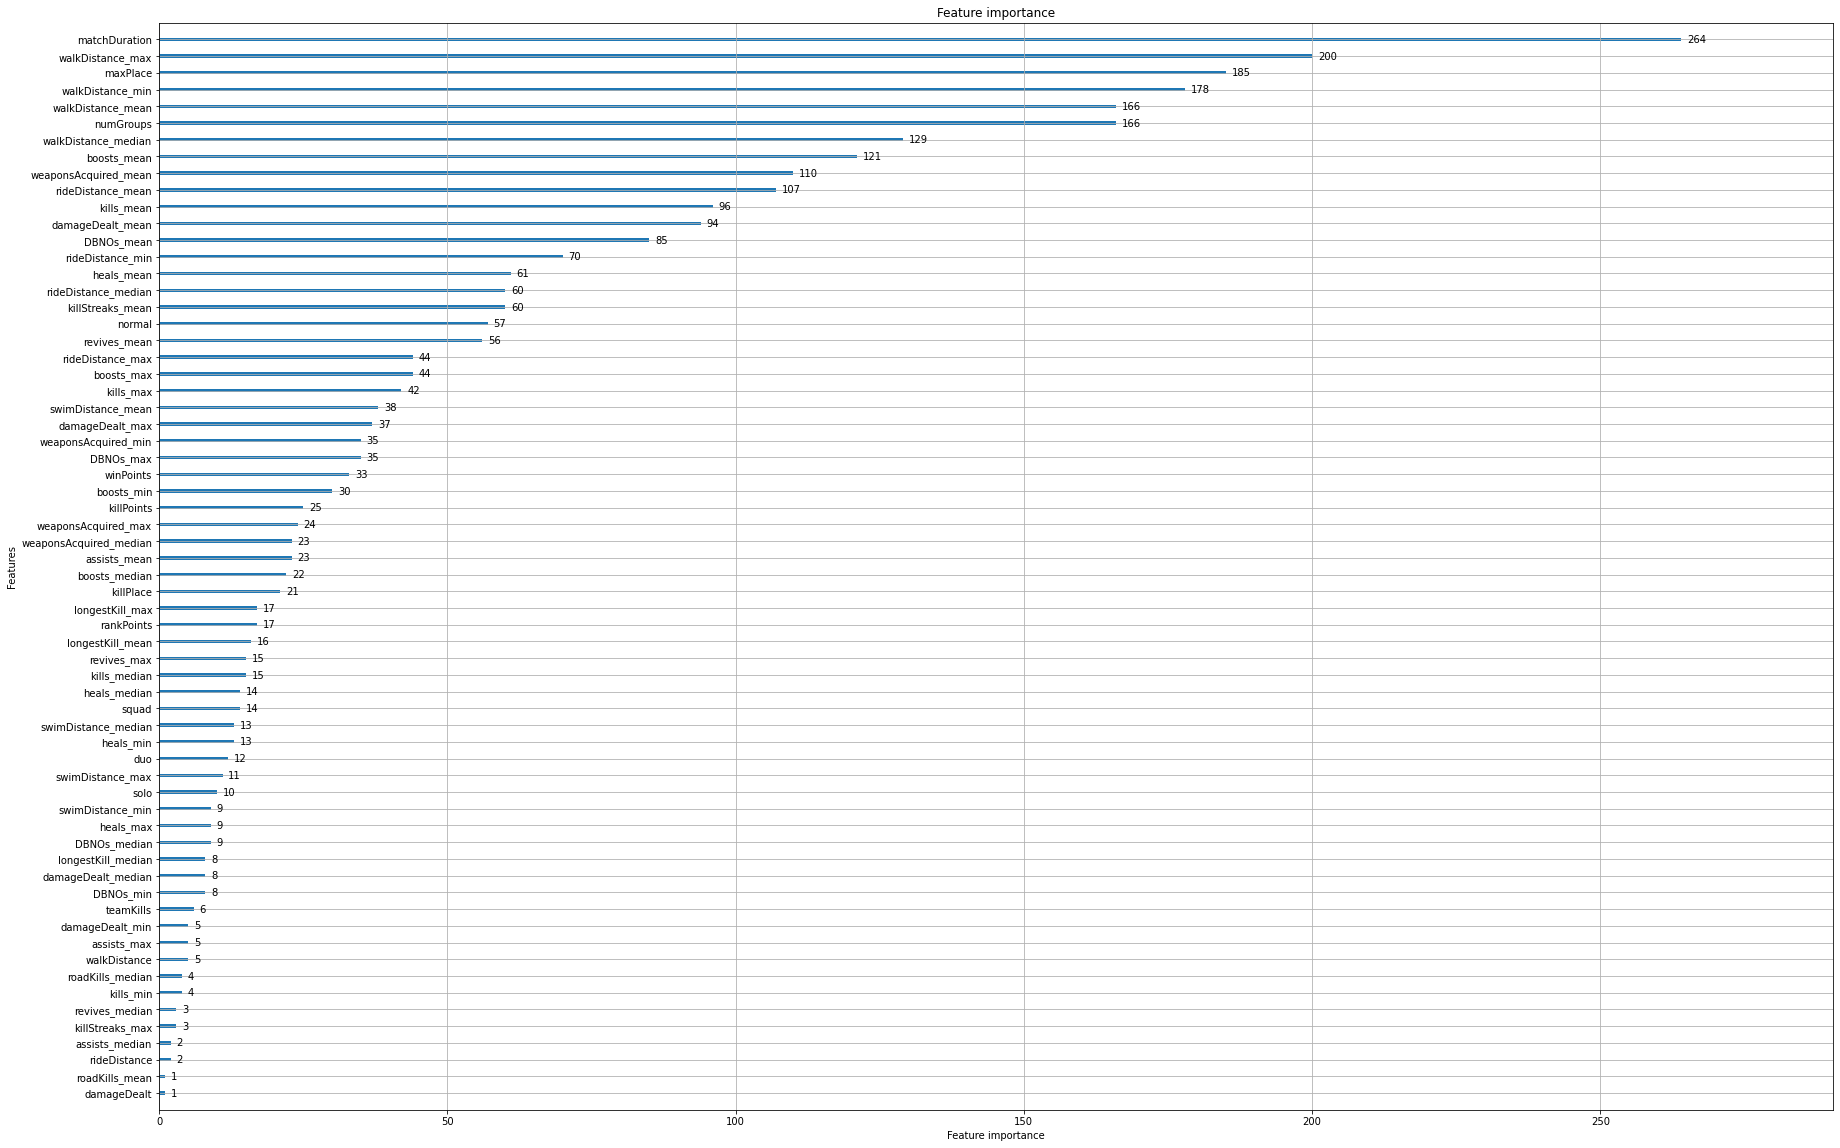

In [51]:
plt.rcParams["figure.figsize"] = (30, 20)
plot_importance(model)

In [ ]:
0.09071973631904867
MAE :  0.090698

### Dummy

        사용한 데이터: 29x4490000의 배그 승률예측 데이터.

__1,__
>편의상 칼럼을 주요 칼럼 4개만 뽑음.

-  df A: 뽑은 칼럼의 이상치 제거(quantile 0.99)
-  df B: 대조군



df A,B를 train set과 validation set로 분리 후 fit-predict. 시드는 서로 같게.    
그 결과, __이상치를 제거한 A가 B보다 성능 악화__ (6개의 시드 시행 전부에서)

-----------
__2,__
>이번엔 전체 데이터에 대해서 동일한 시험 수행.

-  df A: 다수 칼럼의 이상치 제거(quantile 0.99)
-  df B: 대조군

실험 1에서 사용한 6개의 시드 그대로 fit-predict 시행.   
결과는 __이상치를 제거한 A가 B보다 성능이 대체로 우수했음.__ 


-  df C: 모든 칼럼을 사용하되, 실험 1에서 사용한 컬럼 4개에서만 이상치 제거.

마찬가지 실험 결과, __C가 대조군 B보다 성능이 좋았음.__     
실험 1과 상반되는 결과.

-----------



        실험 결과 : 데이터의 크기가 작았을 때는 이상치 제거가 성능을 떨어트렸음.    
                    반면 데이터의 크기가 크다면 이상치 제거가 성능을 올림.
                    크기가 작은 데이터와 동일한 이상치만을 제거했음에도 데이터의 크기가 커지면 오히려 성능을 올리는 요인으로 바뀜.
어째서일까?


사용한 model : lgbm, linear.